# 1 - Data Loading and Preprocessing

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from IPython.display import display
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from math import sqrt

import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree

# Load data and filter realistic ABV range
df = pd.read_csv('recipeData.csv', encoding='ISO-8859-1')
df = df[df['ABV'].between(2, 13)].copy()

# Grouping functions for categorical variables
def group_styles(s):
    if pd.isnull(s):
        return 'Other'
    s = s.lower()
    if 'ipa' in s:        return 'IPA'
    if 'pale ale' in s:   return 'Pale Ale'
    if 'stout' in s:      return 'Stout'
    if 'lager' in s:      return 'Lager'
    if 'porter' in s:     return 'Porter'
    if 'wheat' in s or 'weiss' in s: return 'Wheat'
    return 'Other'

def group_priming_method(x):
    if pd.isnull(x):
        return 'Missing'
    s = str(x).lower()
    if any(k in s for k in ['sugar','azúcar','cane','dextrose','glucose']):
        return 'Sugar'
    if any(k in s for k in ['malt extract','dme','lme','wort']):
        return 'Malt Extract'
    if any(k in s for k in ['honey','miel','syrup']):
        return 'Honey/Syrup'
    if any(k in s for k in ['krausen','gyle']):
        return 'Krausening'
    if any(k in s for k in ['keg','co2','forced']):
        return 'Forced Carb'
    if any(k in s for k in ['tablet','drop']):
        return 'Tablet/Drop'
    return 'Other'

def group_priming_amount(x):
    if pd.isnull(x):
        return 'Missing'
    s = str(x).lower()
    if any(u in s for u in ['gallon','gal']):
        return 'Volume'
    if 'oz' in s:
        return 'Ounces'
    if 'g' in s and 'gal' not in s:
        return 'Grams'
    if any(u in s for u in ['cup','tbsp','tsp']):
        return 'Cups/Spoons'
    if any(u in s for u in ['day','hour','min']):
        return 'Time'
    if any(u.isdigit() for u in s):
        return 'Numeric'
    return 'Other'

# Apply grouping
df['Style_Grouped'] = df['Style'].apply(group_styles)
df['PrimingMethod_grouped'] = df['PrimingMethod'].apply(group_priming_method)
df['PrimingAmount_grouped'] = df['PrimingAmount'].apply(group_priming_amount)

# Drop original columns no longer needed
df.drop(['BeerID','Name','UserId','URL','Style','PrimingMethod','PrimingAmount'], axis=1, inplace=True, errors='ignore')

# Identify numeric and categorical columns
num_cols = df.select_dtypes(include='number').columns.drop('ABV').tolist()
cat_cols = df.select_dtypes(include='object').columns.tolist()

# Manual imputation and rare-level grouping (<2%)
# Numeric columns: fill missing with median
for c in num_cols:
    df[c].fillna(df[c].median(), inplace=True)

# Categorical columns: fill missing, then group rare categories into 'Other'
for c in cat_cols:
    df[c] = df[c].fillna('Missing').astype(str)
    freq = df[c].value_counts(normalize=True)
    rare_vals = freq[freq < 0.02].index
    df[c].replace(list(rare_vals), 'Other', inplace=True)

# Feature engineering
df['OG_minus_FG'] = df['OG'] - df['FG']
df['IBU_to_OG']   = df['IBU'] / df['OG']
df['IBU_to_FG']   = df['IBU'] / df['FG']

# Feature Interactions
df['OGxIBU']             = df['OG_minus_FG'] * df['IBU']
df['OGxEfficiency']      = df['OG_minus_FG'] * df['Efficiency']
df['IBU_to_OG_x_OG_minus_FG'] = df['IBU_to_OG'] * df['OG_minus_FG']

# Recompute numeric & categorical columns now that tenemos OG_minus_FG, IBU_to_OG, IBU_to_FG
num_cols = df.select_dtypes(include='number').columns.drop('ABV').tolist()
cat_cols = df.select_dtypes(include='object').columns.tolist()

/tmp/ipython-input-787402323.py:94: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[c].fillna(df[c].median(), inplace=True)
/tmp/ipython-input-787402323.py:101: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using '

# 2 - Modeling Pipeline

In [2]:
# Complete pipeline: preprocessing + feature selection + modeling
# Scaling
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('power', PowerTransformer(method='yeo-johnson')),
        ('scale', RobustScaler())
    ]), num_cols + ['OG_minus_FG','IBU_to_OG','IBU_to_FG']),
    ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_cols)
])

pipeline = Pipeline([
    ('pre', preprocessor),
    ('select', SelectKBest(score_func=f_regression, k=30)),
    ('model', RidgeCV(alphas=[0.01,0.1,1,10], cv=5))
])


# Pipeline split
X_pipe = df.drop(columns='ABV')
y_pipe = df['ABV']

X_train_pipe, X_test_pipe, y_train_pipe, y_test_pipe = train_test_split(X_pipe, y_pipe, test_size=0.4, random_state=42)
pipeline.fit(X_train_pipe, y_train_pipe)

best_tree = pipeline.named_steps['model']
select    = pipeline.named_steps['select']
pre       = pipeline.named_steps['pre']

# 3 - Decision Tree Models

Maximal tree → R² = 0.991, MSE = 0.021, Leaves = 37630, Depth = 50
Chosen ccp_alpha = 0.00000 (CV MSE = 0.021)
Pruned (ASE) tree → R² = 0.991, MSE = 0.021, Leaves = 37630, Depth = 50
Misclassification tree → Accuracy = 0.979, Leaves = 568, Depth = 27

SUMMARY:
• Maximal regression tree   → R² = 0.991,   MSE = 0.021,   Leaves = 37630,   Depth = 50
• Pruned (ASE) regression   → R² = 0.991, MSE = 0.021, Leaves = 37630, Depth = 50
• Misclassification (ABV>6) → Accuracy = 0.979, Leaves = 568,   Depth = 27


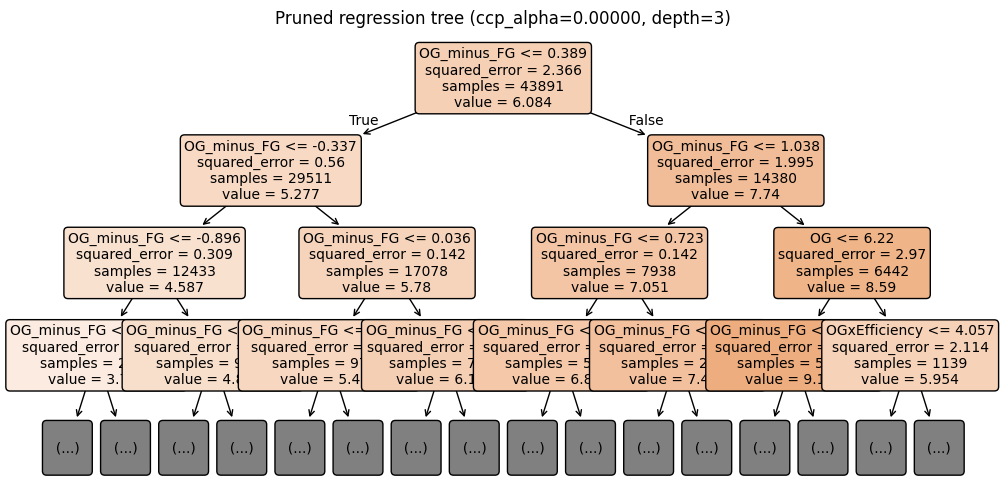

In [3]:
# Split and preprocess
y_reg = df['ABV']
X = df.drop(columns='ABV')
X_train, X_test, y_train, y_test = train_test_split(X, y_reg, test_size=0.4, random_state=42)

# Preprocessing
pre = pipeline.named_steps['pre']
pre.fit(X_train)
Xtr = pre.transform(X_train)
Xte = pre.transform(X_test)

feature_names = (
    num_cols + ['OG_minus_FG','IBU_to_OG','IBU_to_FG'] +
    list(pre.named_transformers_['cat'].get_feature_names_out(cat_cols))
)


# Maximal - unpruned - regression tree
tree_max = DecisionTreeRegressor(random_state=42)
tree_max.fit(Xtr, y_train)
y_pred_max = tree_max.predict(Xte)

r2_max  = r2_score(y_test, y_pred_max)
mse_max = mean_squared_error(y_test, y_pred_max)
leaves_max = tree_max.get_n_leaves()
depth_max  = tree_max.get_depth()

print(f"Maximal tree → R² = {r2_max:.3f}, MSE = {mse_max:.3f}, "
      f"Leaves = {leaves_max}, Depth = {depth_max}")

# ASE‐pruned tree (cost‐complexity pruning)
path = tree_max.cost_complexity_pruning_path(Xtr, y_train)
alphas = path.ccp_alphas

# Sample 20 alphas equally spaced
sampled_alphas = np.linspace(alphas.min(), alphas.max(), 20)
cv_mses = []
for alpha in sampled_alphas:
    t = DecisionTreeRegressor(random_state=42, ccp_alpha=alpha)
    scores = cross_val_score(t, Xtr, y_train,
                             scoring='neg_mean_squared_error', cv=3)
    cv_mses.append(-scores.mean())

best_alpha = sampled_alphas[np.argmin(cv_mses)]
print(f"Chosen ccp_alpha = {best_alpha:.5f} (CV MSE = {min(cv_mses):.3f})")

tree_pruned = DecisionTreeRegressor(random_state=42, ccp_alpha=best_alpha)
tree_pruned.fit(Xtr, y_train)
y_pred_pruned = tree_pruned.predict(Xte)

r2_pruned  = r2_score(y_test, y_pred_pruned)
mse_pruned = mean_squared_error(y_test, y_pred_pruned)
leaves_pruned = tree_pruned.get_n_leaves()
depth_pruned  = tree_pruned.get_depth()

print(f"Pruned (ASE) tree → R² = {r2_pruned:.3f}, MSE = {mse_pruned:.3f}, "
      f"Leaves = {leaves_pruned}, Depth = {depth_pruned}")


# Misclassification tree
# Binarize ABV into Low (<=6%) vs High (>6%)
y_class = (df['ABV'] > 6).astype(int)


Xc_train, Xc_test, yc_train, yc_test = train_test_split(pre.transform(X), y_class, test_size=0.4, random_state=42)

clf = DecisionTreeClassifier(random_state=42)
clf.fit(Xc_train, yc_train)
y_pred_clf = clf.predict(Xc_test)

acc = accuracy_score(yc_test, y_pred_clf)
leaves_clf = clf.get_n_leaves()
depth_clf  = clf.get_depth()

print(f"Misclassification tree → Accuracy = {acc:.3f}, "
      f"Leaves = {leaves_clf}, Depth = {depth_clf}")


# Summary of all models
print("\nSUMMARY:")
print(f"• Maximal regression tree   → R² = {r2_max:.3f},   MSE = {mse_max:.3f},   Leaves = {leaves_max},   Depth = {depth_max}")
print(f"• Pruned (ASE) regression   → R² = {r2_pruned:.3f}, MSE = {mse_pruned:.3f}, Leaves = {leaves_pruned}, Depth = {depth_pruned}")
print(f"• Misclassification (ABV>6) → Accuracy = {acc:.3f}, Leaves = {leaves_clf},   Depth = {depth_clf}")

# Optimal tree:
optimal_tree = tree_pruned
best_tree    = optimal_tree

ohe = preprocessor.named_transformers_['cat']
ohe_cols = list(ohe.get_feature_names_out(cat_cols))
feature_names = num_cols + ['OG_minus_FG','IBU_to_OG','IBU_to_FG'] + ohe_cols

# Plot the pruned regression tree (first 3 levels) for easy explanation
plt.figure(figsize=(12, 6))
plot_tree(
    tree_pruned,
    max_depth=3,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title(f"Pruned regression tree (ccp_alpha={best_alpha:.5f}, depth=3)")
plt.show()

### 3.1 - Shallow Decision Tree with Binned OG

Single tree (max_depth=2): R²=0.700 MSE=0.710


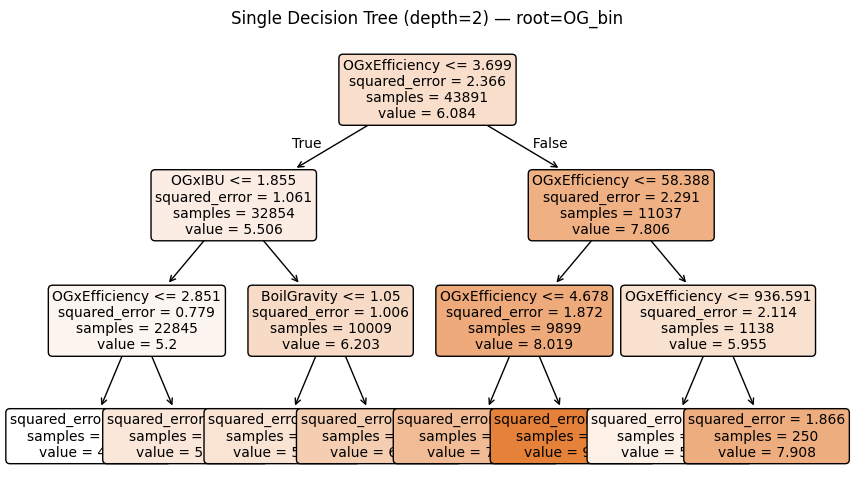

In [4]:
t1, t2 = 0.389, 1.038
df['OG_bin'] = pd.cut(
    df['OG_minus_FG'],
    bins=[-np.inf, t1, t2, np.inf],
    labels=['Low','Medium','High']
)

# X,y without OG, OG_minus_FG
y = df['ABV']
X = df.drop(columns=['ABV', 'OG', 'OG_minus_FG'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


# Only categories
cat_cols = ['OG_bin'] + [c for c in X_train.select_dtypes(include='object').columns
                         if c != 'OG_bin']
# Only numerical
num_cols = [c for c in X_train.select_dtypes(include='number').columns
            if c not in ('OG_minus_FG','OG')]

# Pipeline: one‐hot for OG_bin + passthrough
pre = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
], remainder='passthrough')

pre.fit(X_train)
Xtr = pre.transform(X_train)
Xte = pre.transform(X_test)

# feature names
ohe = pre.named_transformers_['cat']
ohe_cols = ohe.get_feature_names_out(cat_cols).tolist()
feature_names = ohe_cols + num_cols

# tree of depth 2
tree2 = DecisionTreeRegressor(max_depth=3, random_state=42)
tree2.fit(Xtr, y_train)

# Evaluate
y_pred = tree2.predict(Xte)
print("Single tree (max_depth=2):",
      f"R²={r2_score(y_test,y_pred):.3f}",
      f"MSE={mean_squared_error(y_test,y_pred):.3f}"
)

# Plot
plt.figure(figsize=(10,6))
plot_tree(
    tree2,
    feature_names=feature_names,
    filled=True, rounded=True, fontsize=10
)
plt.title("Single Decision Tree (depth=2) — root=OG_bin")
plt.show()

### 3.2 - Pruned Regression Tree Feature Importances

In [5]:
pre = pipeline.named_steps['pre']

feature_names = pre.get_feature_names_out()
clean_names = [fn.split("__", 1)[1] if "__" in fn else fn for fn in feature_names]

importances = tree_pruned.feature_importances_

print(f"Transformed features = {len(clean_names)}")
print(f"Importances in the tree = {importances.shape[0]}")

imp = (pd.Series(importances, index=clean_names).sort_values(ascending=False).head(20))

print("\nTop 20 Feature Importances:")
print(imp)

Transformed features = 35
Importances in the tree = 35

Top 20 Feature Importances:
OG_minus_FG                0.711480
OG_minus_FG                0.169896
OG                         0.092730
OGxEfficiency              0.018231
Efficiency                 0.003743
OGxIBU                     0.000901
Color                      0.000398
FG                         0.000361
BoilGravity                0.000250
Size(L)                    0.000231
BoilSize                   0.000211
StyleID                    0.000206
PrimaryTemp                0.000196
MashThickness              0.000177
IBU_to_OG                  0.000168
PitchRate                  0.000122
BoilTime                   0.000116
IBU                        0.000094
IBU_to_FG                  0.000075
IBU_to_OG_x_OG_minus_FG    0.000075
dtype: float64


# 4 - Regression model

### 4.1 - Full Linear Regression Evaluation

In [6]:
y = df['ABV']
X = df.drop(columns='ABV')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

pipeline.fit(X_train, y_train)
print(f"Optimized Linear Regression Test R²: {r2_score(y_test, pipeline.predict(X_test)):.3f}")

full_r2 = r2_score(y_test, pipeline.predict(X_test))

Optimized Linear Regression Test R²: 0.869


In [7]:
# Full Regression: Top 20 features & coefficients (agrupando duplicados)

selector = pipeline.named_steps['select']
mask     = selector.get_support()

pre       = pipeline.named_steps['pre']
all_feats = pre.get_feature_names_out()

selected_prefixed = [feat for feat, keep in zip(all_feats, mask) if keep]

ridge       = pipeline.named_steps['model']
coef_array  = ridge.coef_

df_coefs = pd.DataFrame({
    'prefixed': selected_prefixed,
    'coef':     coef_array
})
df_coefs['clean'] = df_coefs['prefixed'].apply(lambda s: s.split("__",1)[1] if "__" in s else s)

df_grouped = df_coefs.groupby('clean')['coef'].sum()

top20 = df_grouped.abs().sort_values(ascending=False).head(20).index
top_coef = df_grouped.loc[top20].sort_values(key=lambda x: x.abs(), ascending=False)

print("Top 20 features in Full Regression:")
print(top_coef)


Top 20 features in Full Regression:
clean
SugarScale_Specific Gravity    15.252623
OG_minus_FG                     2.044472
IBU                             1.593424
IBU_to_FG                      -1.134231
IBU_to_OG                      -0.306459
OGxIBU                         -0.134993
OGxEfficiency                  -0.116560
IBU_to_OG_x_OG_minus_FG        -0.109615
Style_Grouped_Stout             0.104858
BrewMethod_extract             -0.103682
Style_Grouped_Other             0.060491
Style_Grouped_Lager             0.054993
Style_Grouped_Wheat             0.050727
Efficiency                      0.049999
OG                              0.027624
Style_Grouped_Pale Ale          0.025495
BrewMethod_Partial Mash        -0.022863
BoilTime                        0.011458
PitchRate                       0.010451
Color                           0.010396
Name: coef, dtype: float64


### Interpreting Top 20 Regression Coefficients

Below are the 20 most influential predictors in the optimized Ridge regression model, ordered by absolute coefficient value:

| Feature                          | Coefficient |
|----------------------------------|------------:|
| SugarScale_Specific Gravity      |     15.2526 |
| OG_minus_FG                      |      2.0445 |
| IBU                              |      1.5934 |
| IBU_to_FG                        |     −1.1342 |
| IBU_to_OG                        |     −0.3065 |
| OG × IBU                         |     −0.1350 |
| OG × Efficiency                  |     −0.1166 |
| IBU_to_OG × OG_minus_FG          |     −0.1096 |
| Style_Grouped_Stout (vs ref)     |      0.1049 |
| BrewMethod_extract (vs ref)      |     −0.1037 |
| Style_Grouped_Other (vs ref)     |      0.0605 |
| Style_Grouped_Lager (vs ref)     |      0.0550 |
| Style_Grouped_Wheat (vs ref)     |      0.0507 |
| Efficiency                       |      0.0500 |
| OG                               |      0.0276 |
| Style_Grouped_Pale Ale (vs ref)  |      0.0255 |
| BrewMethod_Partial Mash (vs ref) |     −0.0229 |
| BoilTime                         |      0.0115 |
| PitchRate                        |      0.0105 |
| Color                            |      0.0104 |

**Key takeaways:**

1. **SugarScale_Specific Gravity (+15.25)**  
   - The strongest predictor: a one-unit increase in specific gravity at packaging corresponds to a 15.25 % increase in ABV, all else equal.

2. **Gravity Drop (OG_minus_FG, +2.04)**  
   - Each point of gravity difference from original to final predicts a 2.04 % rise in ABV—consistent with alcohol yield theory.

3. **Bitterness (IBU, +1.59)**  
   - Higher bitterness correlates with higher ABV: each additional IBU adds about 1.59 % ABV.

4. **Bitterness Ratios (IBU_to_FG, IBU_to_OG)**  
   - Negative coefficients (−1.13, −0.31) suggest that when bitterness is high relative to gravity, ABV tends to drop, perhaps reflecting recipe adjustments to balance high bitterness.

5. **Interaction Effects**  
   - **OG × IBU (−0.135)**: the boost in ABV from bitterness is smaller at higher original gravities.  
   - **OG × Efficiency (−0.117)**: efficiency gains contribute less to ABV when OG is already high.  
   - **IBU_to_OG × OG_minus_FG (−0.110)**: more complex interplay of bitterness ratio and gravity drop.

6. **Style Effects**  
   - **Stouts (+0.105)** have on average 0.105 % higher ABV versus the reference style.  
   - **Lagers (+0.055)** and **wheat beers (+0.051)** also trend higher.  
   - **Extract method (−0.104)** and **partial mash (−0.023)** produce slightly lower ABV than all-grain brewing.

7. **Process Variables**  
   - **Efficiency (+0.050)** and **Original Gravity (OG, +0.028)** moderately raise ABV.  
   - **BoilTime (+0.011)**, **PitchRate (+0.011)**, and **Color (+0.010)** have smaller but positive effects.

> **Interpretation:**  
> Most coefficients align with brewing science: gravity change, bitterness, and process efficiency drive alcohol levels. Style and method variables capture typical ABV differences by beer type. Interaction terms highlight diminishing returns when two key factors—original gravity and bitterness or efficiency—increase simultaneously.


In [8]:
# Reprint the test R² to confirm it hasn’t changed:
print(f"Optimized Linear Regression Test R²: {r2_score(y_test, pipeline.predict(X_test)):.3f}")

# Get the SelectKBest mask (which columns were kept)
mask = pipeline.named_steps['select'].get_support()

# Apply the preprocessor to the TRAINING set (same transforms as pipeline)
X_train_p = pipeline.named_steps['pre'].transform(X_train)
feat_names = pipeline.named_steps['pre'].get_feature_names_out()

# Build a DataFrame, drop duplicated columns, and strip prefixes
df_tr = pd.DataFrame(X_train_p, columns=feat_names, index=X_train.index)
df_tr = df_tr.loc[:, ~df_tr.columns.duplicated()]
clean_cols = [c.split("__", 1)[1] if "__" in c else c for c in df_tr.columns]
df_tr.columns = clean_cols

# Select only the features that the pipeline retained
selected_feats = [clean_cols[i] for i, keep in enumerate(mask) if keep]
X_sel = df_tr[selected_feats]

# Fit an OLS on the TRAINING data to obtain p-values
X_sel_sm = sm.add_constant(X_sel)
ols_sel  = sm.OLS(y_train, X_sel_sm).fit()

# Extract and display ONLY the p-values (without reprinting the OLS R²)
pvals = ols_sel.pvalues.drop('const', errors='ignore')
print("\nP-values for pipeline-selected features:")
print(pvals.sort_values())


Optimized Linear Regression Test R²: 0.869

P-values for pipeline-selected features:
IBU                             0.000000e+00
OG_minus_FG                     0.000000e+00
SugarScale_Specific Gravity     0.000000e+00
OGxEfficiency                  2.097387e-295
IBU_to_FG                      3.504980e-151
Efficiency                      1.043380e-95
Style_Grouped_Stout             7.281675e-73
Style_Grouped_Other             2.828607e-60
BrewMethod_extract              3.939541e-52
IBU_to_OG                       3.392829e-20
Style_Grouped_Lager             4.389313e-19
BoilTime                        5.255612e-16
Style_Grouped_Wheat             3.006039e-15
FG                              1.311902e-14
PitchRate                       3.734903e-14
Style_Grouped_Pale Ale          1.750005e-09
BoilGravity                     1.712317e-05
OG                              2.096549e-05
Style_Grouped_Porter            2.919965e-05
OGxIBU                          3.309243e-04
PrimaryTemp    

### 4.2 - Backward regression

In [9]:
pre = pipeline.named_steps['pre']
pre.fit(X_train)

X_train_p = pre.transform(X_train)
X_test_p  = pre.transform(X_test)

feature_names = pre.get_feature_names_out()

Xtr_full = pd.DataFrame(X_train_p, columns=feature_names, index=X_train.index)
Xte_full = pd.DataFrame(X_test_p,  columns=feature_names, index=X_test.index)

# Delete duplicated columns
Xtr = Xtr_full.loc[:, ~Xtr_full.columns.duplicated()].copy()
Xte = Xte_full.loc[:, ~Xte_full.columns.duplicated()].copy()

clean_cols = [col.split("__", 1)[1] if "__" in col else col for col in Xtr.columns]
Xtr.columns = clean_cols
Xte.columns = clean_cols

ytr = y_train.copy()
yte = y_test.copy()

# AIC function
def AIC(y, y_pred, k):
    n   = len(y)
    rss = np.sum((y - y_pred)**2)
    return n * np.log(rss / n) + 2 * k

# Backward Elimination
def backward_elimination_df(X, y):
    best_feats = list(X.columns)
    y0_pred  = LinearRegression().fit(X[best_feats], y).predict(X[best_feats])
    best_aic = AIC(y, y0_pred, k=len(best_feats) + 1)

    improving = True
    while improving and len(best_feats) > 1:
        improving = False
        trial_results = []
        for f in best_feats:
            trial = [c for c in best_feats if c != f]
            y_pred = LinearRegression().fit(X[trial], y).predict(X[trial])
            trial_results.append((AIC(y, y_pred, k=len(trial) + 1), f))
        trial_results.sort(key=lambda x: x[0])
        if trial_results[0][0] < best_aic:
            best_aic, drop = trial_results[0]
            best_feats.remove(drop)
            improving = True

    return best_feats

# Execute backward elimination
best_back_features = backward_elimination_df(Xtr, ytr)
print("Features selected by backward elimination:")
print(best_back_features)

# Fit the final model and extract coefficients
model_back = LinearRegression().fit(Xtr[best_back_features], ytr)
r2_back = r2_score(yte, model_back.predict(Xte[best_back_features]))
coefs_back = (pd.Series(model_back.coef_, index=best_back_features).sort_values(key=abs, ascending=False))

print(f"\nBackward selection R² on test set: {r2_back:.3f}")
print("\nTop 20 coefficients by absolute value:")
print(coefs_back.head(20))

Features selected by backward elimination:
['Size(L)', 'OG', 'FG', 'IBU', 'Color', 'BoilSize', 'BoilTime', 'BoilGravity', 'Efficiency', 'PitchRate', 'PrimaryTemp', 'OG_minus_FG', 'IBU_to_OG', 'IBU_to_FG', 'OGxIBU', 'OGxEfficiency', 'IBU_to_OG_x_OG_minus_FG', 'SugarScale_Specific Gravity', 'BrewMethod_Partial Mash', 'BrewMethod_extract', 'Style_Grouped_Lager', 'Style_Grouped_Other', 'Style_Grouped_Pale Ale', 'Style_Grouped_Porter', 'Style_Grouped_Stout', 'Style_Grouped_Wheat', 'PrimingMethod_grouped_Sugar', 'PrimingAmount_grouped_Other']

Backward selection R² on test set: 0.869

Top 20 coefficients by absolute value:
SugarScale_Specific Gravity    15.251580
OG_minus_FG                     2.045012
IBU                             1.592582
IBU_to_FG                      -1.138668
IBU_to_OG                      -0.301070
OGxIBU                         -0.151430
OGxEfficiency                  -0.116355
Style_Grouped_Stout             0.114529
BrewMethod_extract             -0.104020
IBU_to

#### 4.2.1 - Backward Selection: p-values via OLS (statsmodels)

In [10]:
# Build a DataFrame of the TRAINING split with only the selected features
X_be = Xtr[best_back_features].copy()

# Add a constant (intercept) column
X_be_sm = sm.add_constant(X_be)

# Fit OLS on the TRAINING data to get p-values
ols_be = sm.OLS(ytr, X_be_sm).fit()

# Reprint the test R² for consistency
print(f"Backward selection R² on test set: {r2_back:.3f}")

# Extract and print only the p-values (dropping the constant)
pvals_be = ols_be.pvalues.drop('const', errors='ignore')
print("\nP-values for backward-selected features:")
print(pvals_be.sort_values())

Backward selection R² on test set: 0.869

P-values for backward-selected features:
IBU                             0.000000e+00
OG_minus_FG                     0.000000e+00
SugarScale_Specific Gravity     0.000000e+00
OGxEfficiency                  2.662064e-295
IBU_to_FG                      3.299024e-151
Efficiency                      1.341427e-95
Style_Grouped_Stout             6.255257e-73
Style_Grouped_Other             2.666695e-60
BrewMethod_extract              2.298654e-54
IBU_to_OG                       3.247716e-20
Style_Grouped_Lager             4.484100e-19
BoilTime                        6.285936e-16
Style_Grouped_Wheat             2.913593e-15
FG                              1.297074e-14
PitchRate                       3.843422e-14
Style_Grouped_Pale Ale          1.738915e-09
BoilGravity                     1.703482e-05
OG                              2.071418e-05
Style_Grouped_Porter            2.894977e-05
OGxIBU                          3.400394e-04
PrimaryTemp      

### 4.3  - Forward regression

In [11]:
features = Xtr.columns.tolist()

# Forward Selection
def forward_selection(features_list):
    best_feats = []
    best_aic = AIC(ytr, np.full_like(ytr, ytr.mean()), k=1)
    remaining = features_list.copy()
    improved = True

    while improved and remaining:
        improved = False
        trial_results = []
        for f in remaining:
            trial = best_feats + [f]
            y_pred = LinearRegression().fit(Xtr[trial], ytr).predict(Xtr[trial])
            trial_results.append((AIC(ytr, y_pred, k=len(trial)+1), f))
        trial_results.sort(key=lambda x: x[0])
        if trial_results[0][0] < best_aic:
            best_aic, add_feat = trial_results[0]
            best_feats.append(add_feat)
            remaining.remove(add_feat)
            improved = True
    return best_feats

# Execute forward selection
best_forw_features = forward_selection(features)
print("Features selected by forward selection:")
print(best_forw_features)

# Fit the final model and extract coefficients
model_forw = LinearRegression().fit(Xtr[best_forw_features], ytr)
r2_forw = r2_score(yte, model_forw.predict(Xte[best_forw_features]))
coefs_forw = (pd.Series(model_forw.coef_, index=best_forw_features).sort_values(key=abs, ascending=False))

print(f"\nForward R² on test set: {r2_forw:.3f}")
print("\nTop coefficients (by absolute value):")
print(coefs_forw)

Features selected by forward selection:
['OG_minus_FG', 'SugarScale_Specific Gravity', 'OGxEfficiency', 'Efficiency', 'BrewMethod_extract', 'Style_Grouped_Stout', 'Style_Grouped_Other', 'BoilTime', 'PitchRate', 'OGxIBU', 'IBU_to_OG_x_OG_minus_FG', 'IBU_to_OG', 'IBU', 'IBU_to_FG', 'FG', 'Style_Grouped_Lager', 'Style_Grouped_Wheat', 'OG', 'Style_Grouped_Pale Ale', 'Style_Grouped_Porter', 'BrewMethod_Partial Mash', 'BoilGravity', 'PrimaryTemp', 'Color', 'PrimingMethod_grouped_Sugar', 'PrimingAmount_grouped_Other']

Forward R² on test set: 0.869

Top coefficients (by absolute value):
SugarScale_Specific Gravity    15.251102
OG_minus_FG                     2.044747
IBU                             1.593730
IBU_to_FG                      -1.140291
IBU_to_OG                      -0.300616
OGxIBU                         -0.150755
OGxEfficiency                  -0.116085
Style_Grouped_Stout             0.114708
BrewMethod_extract             -0.112705
IBU_to_OG_x_OG_minus_FG        -0.091340
Sty

#### 4.3.1 - Forward Selection: p-values via OLS (statsmodels)

In [12]:
# Build a DataFrame of the TRAINING split with only the forward‐selected features
X_fs = Xtr[best_forw_features].copy()

# Add the constant (intercept)
X_fs_sm = sm.add_constant(X_fs)

# Fit OLS on the TRAINING data to get p-values
ols_fs = sm.OLS(ytr, X_fs_sm).fit()

# Reprint the test R² for consistency
print(f"Forward selection R² on test set: {r2_forw:.3f}")

# Extract and print only the p-values (dropping the constant)
pvals_fs = ols_fs.pvalues.drop('const', errors='ignore')
print("\nP-values for forward-selected features:")
print(pvals_fs.sort_values())

Forward selection R² on test set: 0.869

P-values for forward-selected features:
OG_minus_FG                     0.000000e+00
SugarScale_Specific Gravity     0.000000e+00
IBU                             0.000000e+00
OGxEfficiency                  3.239714e-294
IBU_to_FG                      1.231112e-151
Efficiency                      1.768558e-96
BrewMethod_extract              2.852728e-81
Style_Grouped_Stout             3.561733e-73
Style_Grouped_Other             1.126016e-60
IBU_to_OG                       3.713960e-20
Style_Grouped_Lager             2.918098e-19
BoilTime                        6.259624e-17
Style_Grouped_Wheat             1.844009e-15
FG                              1.194227e-14
PitchRate                       4.084542e-14
Style_Grouped_Pale Ale          1.576200e-09
BrewMethod_Partial Mash         2.014114e-06
OG                              1.573503e-05
Style_Grouped_Porter            2.791571e-05
BoilGravity                     9.728941e-05
OGxIBU             

### 4.4 - Stepwise selection

In [13]:
features = Xtr.columns.tolist()

# Stepwise selection
def stepwise_selection(features_list):
    best_feats = []
    best_aic = AIC(ytr, np.full_like(ytr, ytr.mean()), k=1)
    improving = True

    while improving:
        improving = False
        #forward
        for f in [c for c in features_list if c not in best_feats]:
            trial = best_feats + [f]
            y_pred = LinearRegression().fit(Xtr[trial], ytr).predict(Xtr[trial])
            aic = AIC(ytr, y_pred, k=len(trial) + 1)
            if aic < best_aic:
                best_aic = aic
                best_feats.append(f)
                improving = True
                break
        if improving:
            continue
        #backward
        for f in best_feats.copy():
            trial = [c for c in best_feats if c != f]
            if not trial:
                continue
            y_pred = LinearRegression().fit(Xtr[trial], ytr).predict(Xtr[trial])
            aic = AIC(ytr, y_pred, k=len(trial) + 1)
            if aic < best_aic:
                best_aic = aic
                best_feats.remove(f)
                improving = True
                break
    return best_feats

# Execute stepwise selection
best_step_features = stepwise_selection(features)
print("Features selected by stepwise selection:")
print(best_step_features)

# Fit the final model and extract coefficients
model_step = LinearRegression().fit(Xtr[best_step_features], ytr)
r2_step = r2_score(yte, model_step.predict(Xte[best_step_features]))
coefs_step = (
    pd.Series(model_step.coef_, index=best_step_features)
      .sort_values(key=abs, ascending=False)
)

print(f"\nStepwise R² on test set: {r2_step:.3f}")
print("\nTop coefficients (by absolute value):")
print(coefs_step)

Features selected by stepwise selection:
['Size(L)', 'OG', 'FG', 'IBU', 'Color', 'BoilSize', 'BoilTime', 'BoilGravity', 'Efficiency', 'PitchRate', 'PrimaryTemp', 'OG_minus_FG', 'IBU_to_OG', 'IBU_to_FG', 'OGxIBU', 'OGxEfficiency', 'IBU_to_OG_x_OG_minus_FG', 'SugarScale_Specific Gravity', 'BrewMethod_Partial Mash', 'BrewMethod_extract', 'Style_Grouped_Lager', 'Style_Grouped_Other', 'Style_Grouped_Pale Ale', 'Style_Grouped_Porter', 'Style_Grouped_Stout', 'Style_Grouped_Wheat', 'PrimingMethod_grouped_Sugar', 'PrimingAmount_grouped_Other']

Stepwise R² on test set: 0.869

Top coefficients (by absolute value):
SugarScale_Specific Gravity    15.251580
OG_minus_FG                     2.045012
IBU                             1.592582
IBU_to_FG                      -1.138668
IBU_to_OG                      -0.301070
OGxIBU                         -0.151430
OGxEfficiency                  -0.116355
Style_Grouped_Stout             0.114529
BrewMethod_extract             -0.104020
IBU_to_OG_x_OG_minu

#### 4.4.1 - Stepwise Selection: p-values via OLS (statsmodels)

In [14]:
# Build a DataFrame of the TRAINING split with only the stepwise‐selected features
X_sw = Xtr[best_step_features].copy()

# Add the constant (intercept)
X_sw_sm = sm.add_constant(X_sw)

# Fit OLS on the TRAINING data to get p-values
ols_sw = sm.OLS(ytr, X_sw_sm).fit()

# Reprint the test R² for consistency
print(f"Stepwise selection R² on test set: {r2_step:.3f}")

# Extract and print only the p-values (dropping the constant)
pvals_sw = ols_sw.pvalues.drop('const', errors='ignore')
print("\nP-values for stepwise-selected features:")
print(pvals_sw.sort_values())

Stepwise selection R² on test set: 0.869

P-values for stepwise-selected features:
IBU                             0.000000e+00
OG_minus_FG                     0.000000e+00
SugarScale_Specific Gravity     0.000000e+00
OGxEfficiency                  2.662064e-295
IBU_to_FG                      3.299024e-151
Efficiency                      1.341427e-95
Style_Grouped_Stout             6.255257e-73
Style_Grouped_Other             2.666695e-60
BrewMethod_extract              2.298654e-54
IBU_to_OG                       3.247716e-20
Style_Grouped_Lager             4.484100e-19
BoilTime                        6.285936e-16
Style_Grouped_Wheat             2.913593e-15
FG                              1.297074e-14
PitchRate                       3.843422e-14
Style_Grouped_Pale Ale          1.738915e-09
BoilGravity                     1.703482e-05
OG                              2.071418e-05
Style_Grouped_Porter            2.894977e-05
OGxIBU                          3.400394e-04
PrimaryTemp      

### 4.5 - Regression model comparison

In [15]:
pipeline.fit(X_train, y_train)
full_r2 = r2_score(y_test, pipeline.predict(X_test))

back_feats  = backward_elimination_df(Xtr, ytr)
forw_feats  = forward_selection(Xtr.columns.tolist())
step_feats  = stepwise_selection(Xtr.columns.tolist())


model = LinearRegression()

back_r2  = r2_score(yte,
           model.fit(Xtr[back_feats], ytr)
                .predict(Xte[back_feats]))

forw_r2  = r2_score(yte,
           model.fit(Xtr[forw_feats], ytr)
                .predict(Xte[forw_feats]))

step_r2  = r2_score(yte,
           model.fit(Xtr[step_feats], ytr)
                .predict(Xte[step_feats]))

print(f"Full regression    R² = {full_r2:.5f}")
print(f"Backward selection R² = {back_r2:.5f}")
print(f"Forward selection  R² = {forw_r2:.5f}")
print(f"Stepwise selection R² = {step_r2:.5f}")

Full regression    R² = 0.86909
Backward selection R² = 0.86911
Forward selection  R² = 0.86884
Stepwise selection R² = 0.86911


### 4.6 - Model Predictions & Residual Analysis

In [16]:
def compare_predictions(model, X, y, model_name="Model"):
    y_pred = model.predict(X)
    df = pd.DataFrame({
        'Actual_ABV':         y.values,
        f'Predicted_ABV_{model_name}': y_pred,
        'Residual':           y.values - y_pred,
        'Absolute_Error':     np.abs(y.values - y_pred),
        'Squared_Error':      (y.values - y_pred)**2
    }, index=y.index).reset_index(drop=True)
    return df

comparison_df = compare_predictions(pipeline, X_test, y_test, model_name="FullReg")

print(comparison_df.head(20))

    Actual_ABV  Predicted_ABV_FullReg  Residual  Absolute_Error  Squared_Error
0         6.26               6.396723 -0.136723        0.136723       0.018693
1         7.47               7.731155 -0.261155        0.261155       0.068202
2        10.68              10.308974  0.371026        0.371026       0.137660
3         4.23               3.896189  0.333811        0.333811       0.111430
4         6.14               6.205297 -0.065297        0.065297       0.004264
5         6.38               6.447064 -0.067064        0.067064       0.004498
6         5.27               5.280805 -0.010805        0.010805       0.000117
7         4.75               4.653533  0.096467        0.096467       0.009306
8         9.23               9.094430  0.135570        0.135570       0.018379
9         7.24               7.287500 -0.047500        0.047500       0.002256
10        3.13               2.871443  0.258557        0.258557       0.066852
11        7.39               7.339212  0.050788     

### 4.7 - Full Regression Error Metrics

In [17]:
me   = (y_test - y_pred).mean()
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
mape = (np.abs(y_test - y_pred) / y_test).mean() * 100

print(f"ME   : {me:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"MAPE : {mape:.2f}%")

ME   : -0.0000
RMSE : 0.8425
MAE  : 0.5940
MAPE : 10.13%


### 4.8 - Full Regression Residual Analysis

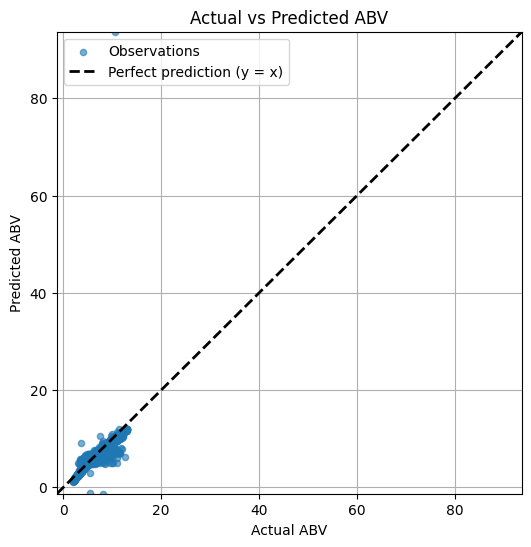

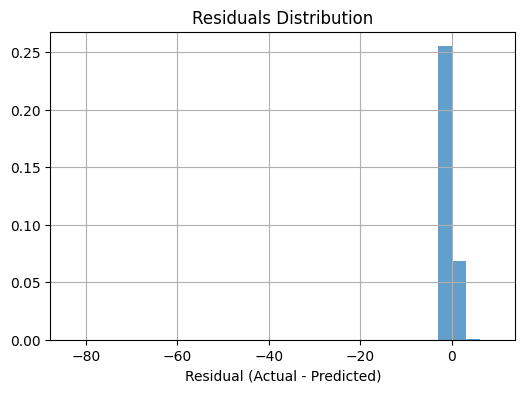

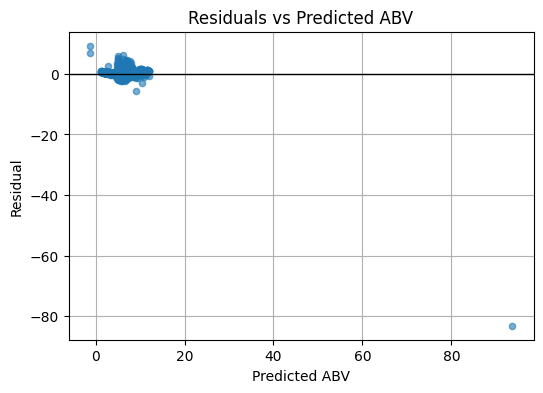

In [18]:
y_pred   = pipeline.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, s=20, label='Observations')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'k--', lw=2, label='Perfect prediction (y = x)')
plt.xlim(lims); plt.ylim(lims)
plt.xlabel('Actual ABV'); plt.ylabel('Predicted ABV')
plt.title('Actual vs Predicted ABV')
plt.legend(); plt.grid(True)

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, density=True, alpha=0.7)
plt.xlabel('Residual (Actual - Predicted)')
plt.title('Residuals Distribution')
plt.grid(True)

plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.6, s=20)
plt.axhline(0, color='k', lw=1)
plt.xlabel('Predicted ABV'); plt.ylabel('Residual')
plt.title('Residuals vs Predicted ABV')
plt.grid(True)

plt.show()

# 5 -  Random forest

In [19]:
pre = pipeline.named_steps['pre']
pre.fit(X_train)

Xtr = pre.transform(X_train)
Xte = pre.transform(X_test)

feat_names = pre.get_feature_names_out()

Xtr_df = pd.DataFrame(Xtr, columns=feat_names, index=X_train.index)
Xte_df = pd.DataFrame(Xte, columns=feat_names, index=X_test.index)
Xtr_df = Xtr_df.loc[:, ~Xtr_df.columns.duplicated()]
Xte_df = Xte_df.loc[:, ~Xte_df.columns.duplicated()]
print("Prepared Xtr_df/Xte_df with shape:", Xtr_df.shape, Xte_df.shape)

clean_cols = [c.split("__", 1)[1] if "__" in c else c for c in Xtr_df.columns]
Xtr_df.columns = clean_cols
Xte_df.columns = clean_cols
print("Columns after renaming:", Xtr_df.columns.tolist())

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(Xtr_df, y_train)

y_pred_rf = rf.predict(Xte_df)
rf_r2     = r2_score(y_test, y_pred_rf)
rf_mse    = mean_squared_error(y_test, y_pred_rf)

rf_importances = (pd.Series(rf.feature_importances_, index=Xtr_df.columns).sort_values(ascending=False).head(20))

print(f"Random Forest R² on test set: {rf_r2:.3f}")
print(f"Random Forest MSE on test set: {rf_mse:.3f}\n")
print("Top 20 feature importances:")
print(rf_importances)

Prepared Xtr_df/Xte_df with shape: (43891, 32) (29261, 32)
Columns after renaming: ['StyleID', 'Size(L)', 'OG', 'FG', 'IBU', 'Color', 'BoilSize', 'BoilTime', 'BoilGravity', 'Efficiency', 'MashThickness', 'PitchRate', 'PrimaryTemp', 'OG_minus_FG', 'IBU_to_OG', 'IBU_to_FG', 'OGxIBU', 'OGxEfficiency', 'IBU_to_OG_x_OG_minus_FG', 'SugarScale_Specific Gravity', 'BrewMethod_BIAB', 'BrewMethod_Partial Mash', 'BrewMethod_extract', 'Style_Grouped_Lager', 'Style_Grouped_Other', 'Style_Grouped_Pale Ale', 'Style_Grouped_Porter', 'Style_Grouped_Stout', 'Style_Grouped_Wheat', 'PrimingMethod_grouped_Other', 'PrimingMethod_grouped_Sugar', 'PrimingAmount_grouped_Other']
Random Forest R² on test set: 0.995
Random Forest MSE on test set: 0.011

Top 20 feature importances:
OG_minus_FG                    0.908738
OG                             0.041241
OGxEfficiency                  0.026497
SugarScale_Specific Gravity    0.012952
Efficiency                     0.003163
BoilGravity                    0.0025

**Key takeaways:**

1. **Gravity Drop (OG_minus_FG)**  
   - By far the strongest predictor (≈ 90.9% of total importance). This directly reflects how much sugar was converted to alcohol, so it makes sense that it dominates.

2. **Original Gravity (OG)**  
   - The second most important (≈ 4.1%). Higher starting gravity generally leads to higher potential ABV.

3. **Interaction OG × Efficiency**  
   - Contributes about 2.65%. Indicates that process efficiency has a larger effect on ABV when the original gravity is high.

4. **Packaging Gravity (SugarScale_Specific Gravity)**  
   - Adds about 1.30%. This final gravity reading at packaging refines the ABV estimate.

5. **Process Variables**  
   - Efficiency (0.32%), BoilGravity (0.26%), and FG (0.13%) each make small but meaningful contributions, capturing nuances of fermentation performance.

6. **Bitterness & Interactions**  
   - OG × IBU, IBU_to_OG × OG_minus_FG, IBU, and IBU_to_FG each contribute < 0.1%. They show that bitterness and its ratio to gravity slightly refine predictions.

7. **Categorical and ID Variables**  
   - StyleID and others rank very low (< 0.0003), meaning beer style or priming method has minimal incremental impact once the key numeric features are accounted for.

> **Conclusion:**  
> The Random Forest confirms that **gravity drop** (difference between OG and FG) is overwhelmingly the best predictor of ABV. Secondary factors such as original gravity, efficiency, and specific gravity in packaging fine-tune the estimate, while categorical factors play only a minor role.  

### 5.1 - Random Forest: Top Feature and Target Visualizations

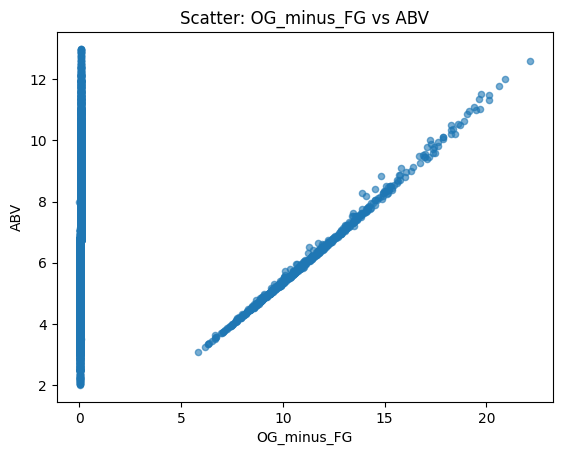

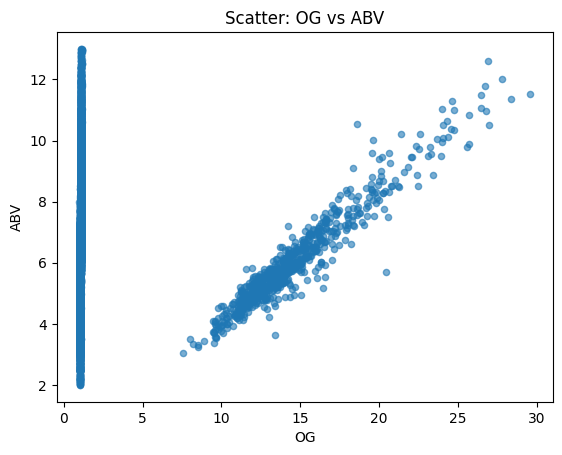

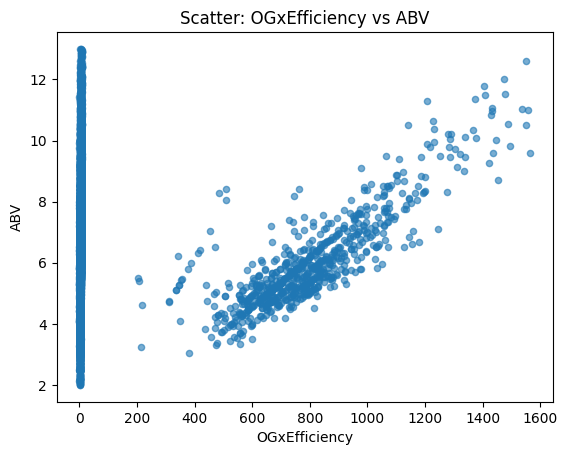

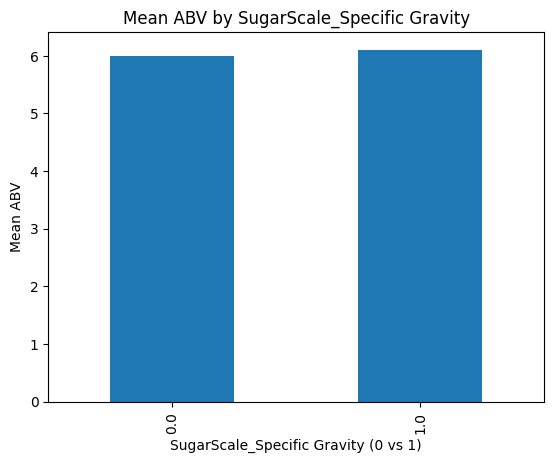

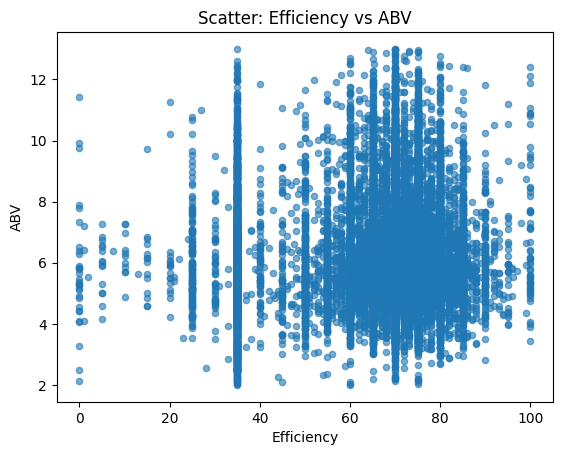

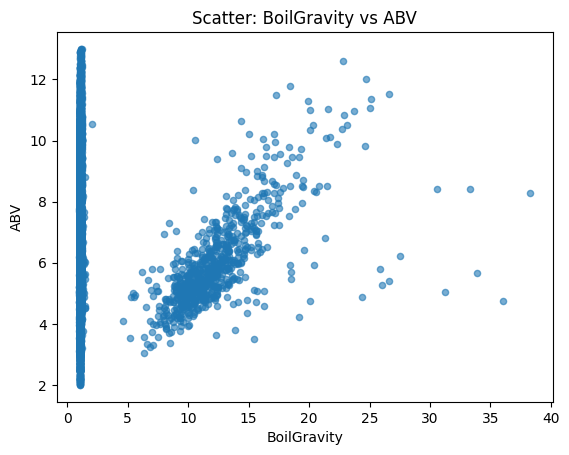

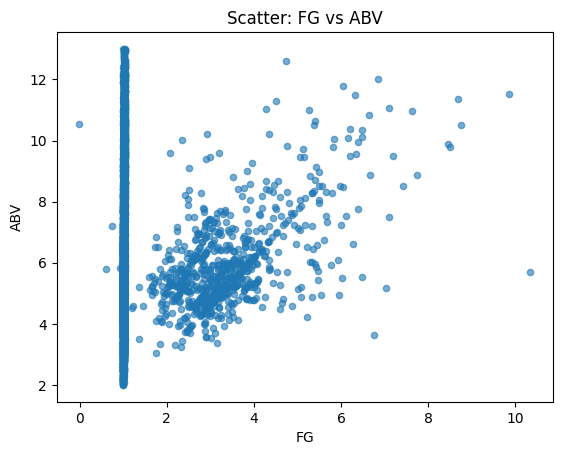

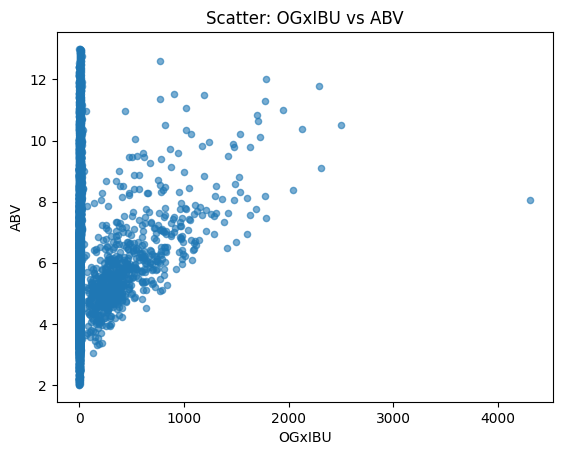

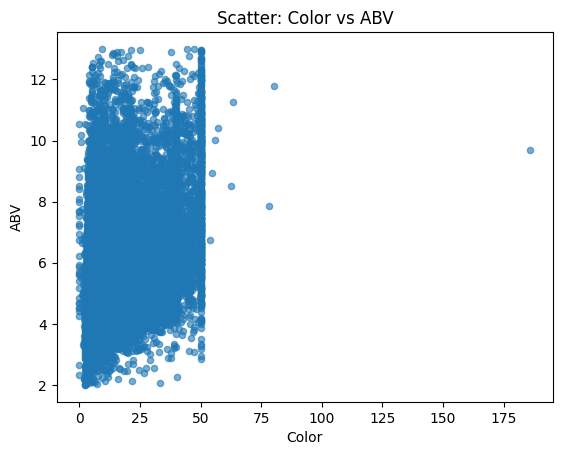

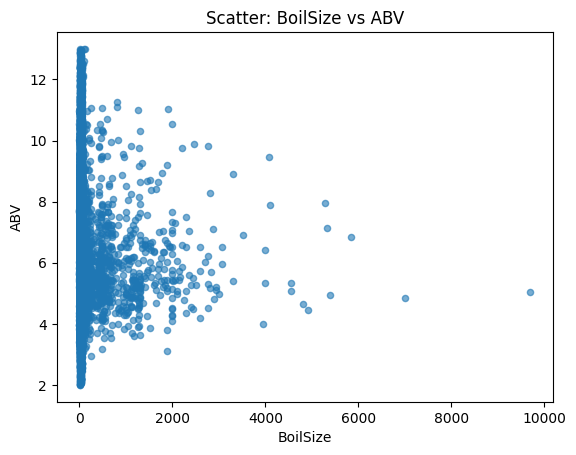

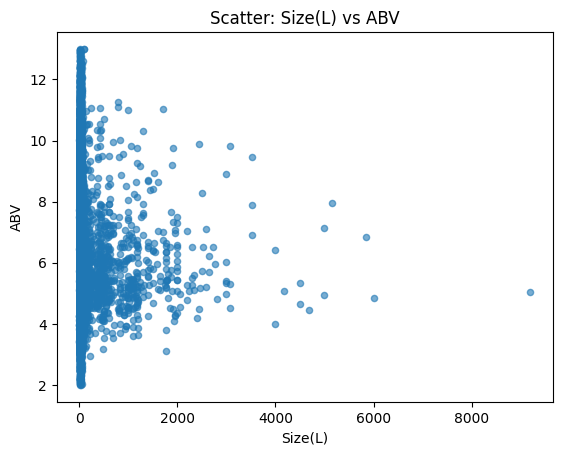

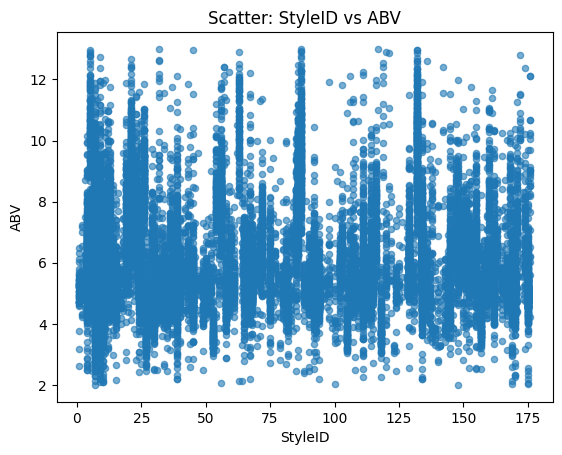

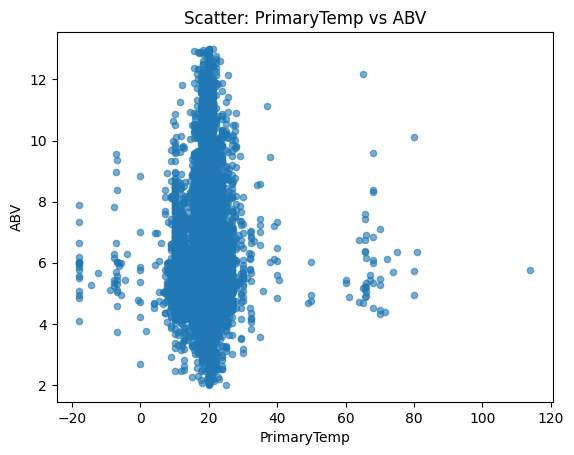

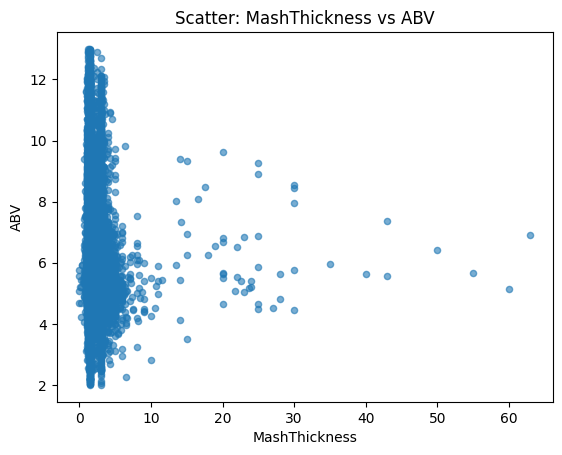

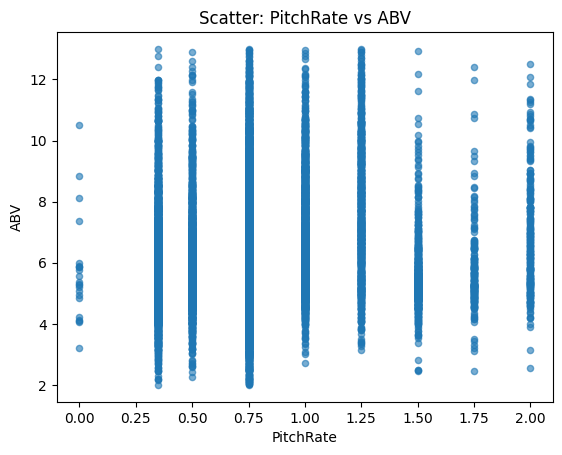

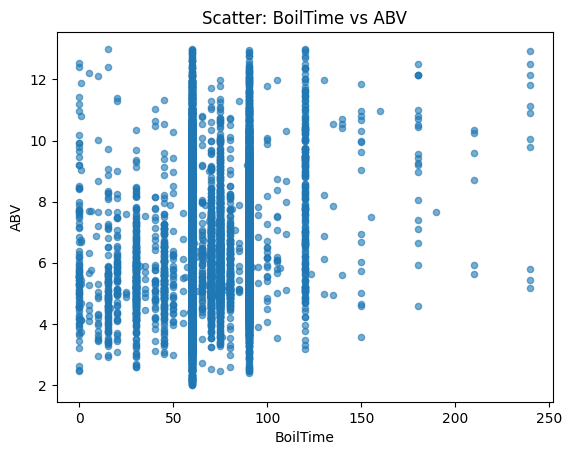

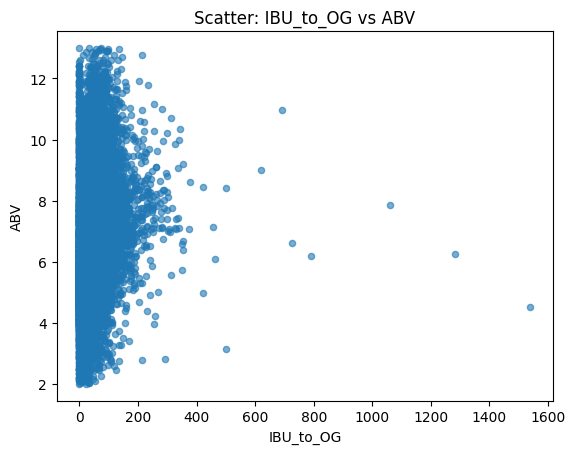

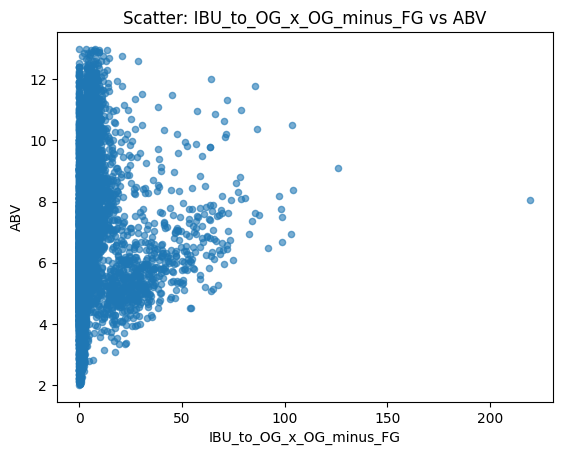

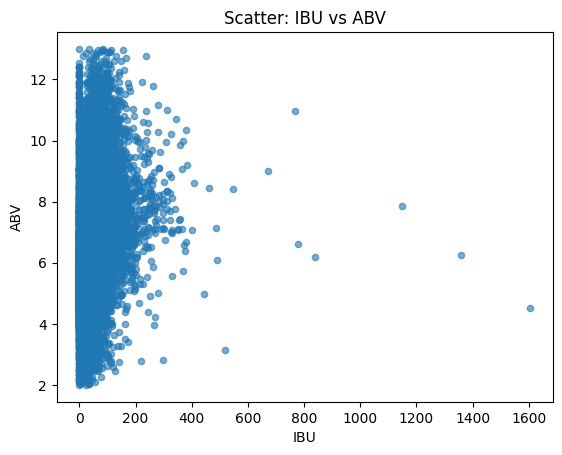

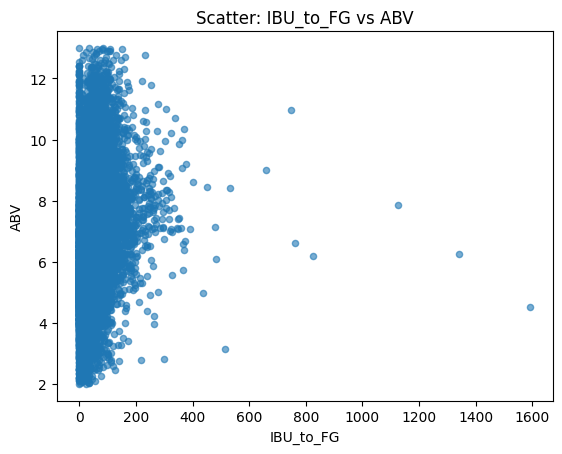

In [20]:
# top_feats comes from your RF importances:
top_feats = rf_importances.index.tolist()

# the raw test‐set df
X_raw = X_test.copy()

for feat in top_feats:
    if feat in X_raw.columns and pd.api.types.is_numeric_dtype(X_raw[feat]):
        # Numeric scatter
        plt.figure()
        plt.scatter(X_raw[feat], y_test, alpha=0.6, s=20)
        plt.xlabel(feat)
        plt.ylabel('ABV')
        plt.title(f'Scatter: {feat} vs ABV')
        plt.show()

    elif feat in X_raw.columns and pd.api.types.is_object_dtype(X_raw[feat]):
        # Raw categorical: bar chart of mean ABV per category
        df_tmp = pd.concat([X_raw[feat], y_test.rename('ABV')], axis=1)
        means  = df_tmp.groupby(feat)['ABV'].mean().sort_values()
        plt.figure()
        means.plot(kind='bar')
        plt.xlabel(feat)
        plt.ylabel('Mean ABV')
        plt.title(f'Mean ABV by {feat}')
        plt.show()

    elif feat in Xte_df.columns:
        # Dummy OHE column (0/1): bar chart of mean ABV for 0 vs 1
        df_tmp = pd.DataFrame({
            'dummy': Xte_df[feat],
            'ABV':   y_test
        })
        means = df_tmp.groupby('dummy')['ABV'].mean()
        plt.figure()
        means.plot(kind='bar')
        plt.xlabel(feat + ' (0 vs 1)')
        plt.ylabel('Mean ABV')
        plt.title(f'Mean ABV by {feat}')
        plt.show()

    else:
        print(f"Feature not found in either raw X_test or Xte_df: {feat}")

### 5.2 - Regression Model Performance Metrics

In [21]:
# Prepare preprocessed arrays and DataFrames
pre = pipeline.named_steps['pre']
X_test_p = pre.transform(X_test)

feat_names = pre.get_feature_names_out()
Xtr_full  = pd.DataFrame(pre.transform(X_train), columns=feat_names, index=X_train.index)
Xte_full  = pd.DataFrame(X_test_p,         columns=feat_names, index=X_test.index)
Xtr_df    = Xtr_full.loc[:, ~Xtr_full.columns.duplicated()].copy()
Xte_df    = Xte_full.loc[:, ~Xte_full.columns.duplicated()].copy()
clean_cols = [c.split("__",1)[1] if "__" in c else c for c in Xtr_df.columns]
Xtr_df.columns = clean_cols
Xte_df.columns = clean_cols

# Helper to print R² and error metrics
def print_metrics(y_true, y_pred, name="Model"):
    r2   = r2_score(y_true, y_pred)
    me   = np.mean(y_true - y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"{name} → R²: {r2:.4f}, ME: {me:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

# Full regression (pipeline)
y_full = pipeline.predict(X_test)
print_metrics(y_test, y_full, name="Full Regression")

# Maximal regression tree
y_max = tree_max.predict(X_test_p)
print_metrics(y_test, y_max, name="Max Tree")

# Pruned regression tree
y_pruned = tree_pruned.predict(X_test_p)
print_metrics(y_test, y_pruned, name="Pruned Tree")

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(Xtr_df, y_train)
y_rf = rf.predict(Xte_df)
print_metrics(y_test, y_rf, name="Random Forest")

# Backward-selected Linear
y_back = LinearRegression().fit(Xtr_df[back_feats], y_train).predict(Xte_df[back_feats])
print_metrics(y_test, y_back, name="Backward Selection")

# Forward-selected Linear
y_forw = LinearRegression().fit(Xtr_df[forw_feats], y_train).predict(Xte_df[forw_feats])
print_metrics(y_test, y_forw, name="Forward Selection")

# Stepwise-selected Linear
y_step = LinearRegression().fit(Xtr_df[step_feats], y_train).predict(Xte_df[step_feats])
print_metrics(y_test, y_step, name="Stepwise Selection")

Full Regression → R²: 0.8691, ME: -0.0029, RMSE: 0.5566, MAE: 0.1324, MAPE: 2.24%
Max Tree → R²: 0.9912, ME: -0.0028, RMSE: 0.1443, MAE: 0.0762, MAPE: 1.26%
Pruned Tree → R²: 0.9912, ME: -0.0028, RMSE: 0.1443, MAE: 0.0762, MAPE: 1.26%
Random Forest → R²: 0.9954, ME: -0.0025, RMSE: 0.1039, MAE: 0.0550, MAPE: 0.91%
Backward Selection → R²: 0.8691, ME: -0.0029, RMSE: 0.5565, MAE: 0.1323, MAPE: 2.24%
Forward Selection → R²: 0.8688, ME: -0.0029, RMSE: 0.5571, MAE: 0.1323, MAPE: 2.24%
Stepwise Selection → R²: 0.8691, ME: -0.0029, RMSE: 0.5565, MAE: 0.1323, MAPE: 2.24%


# 6 - Neural Networks

### 6.1 - Neural Network Regression - MLP Pipeline

---



In [22]:
mlp_pipe = Pipeline([
    ('pre', pre),
    ('mlp', MLPRegressor(
        hidden_layer_sizes=(64,32),
        activation='relu',
        solver='adam',
        learning_rate_init=1e-3,
        early_stopping=True,
        n_iter_no_change=20,
        max_iter=2000,
        random_state=42
    ))
])

mlp_pipe.fit(X_train, y_train)
y_pred_mlp = mlp_pipe.predict(X_test)

mlp_r2  = r2_score(y_test, y_pred_mlp)
mlp_mse = mean_squared_error(y_test, y_pred_mlp)

print(f"MLP pipeline R²: {mlp_r2:.3f}")
print(f"MLP pipeline MSE: {mlp_mse:.3f}")

MLP pipeline R²: 0.982
MLP pipeline MSE: 0.042


### 6.2 - Deep Neural Network Regression - Keras MLP

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1098/1098 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 10.1887 - val_loss: 0.1998
Epoch 2/20
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.2838 - val_loss: 0.1383
Epoch 3/20
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.2815 - val_loss: 0.1118
Epoch 4/20
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0753 - val_loss: 0.1215
Epoch 5/20
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7297 - val_loss: 0.1717
Epoch 6/20
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.4270 - val_loss: 0.1180
Epoch 7/20
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6694 - val_loss: 0.0908
Epoch 8/20
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.7380 - val_loss: 0.1108
Epoch 9/20
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.4141 - val_loss: 0.1186
Epoch 10/20
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6435 - val_loss: 0.0921
Epoch 11/20
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2609 - val_loss: 0.0837
Epoch 12/20
1098/1098 ━━━━━━━━━━━━━━━━━━

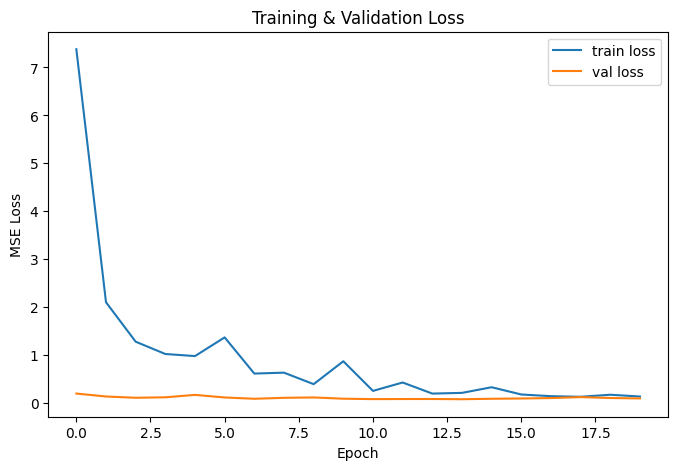

In [23]:
X = df.drop(columns='ABV')
y = df['ABV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

pre.fit(X_train)

Xtr_full = pre.transform(X_train)
Xte_full = pre.transform(X_test)

Xtr = Xtr_full
Xte = Xte_full

# Regression model with Keras
def build_regressor(input_dim):
    m = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    m.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
    return m

# Early stopping callback
es = EarlyStopping( monitor='val_loss', patience=10, restore_best_weights=True)

# Train
model_nn = build_regressor(Xtr.shape[1])
history = model_nn.fit( Xtr, y_train, validation_split=0.2, epochs=20, batch_size=32, callbacks=[es], verbose=1)

y_pred_nn = model_nn.predict(Xte).flatten()
nn_r2  = r2_score(y_test, y_pred_nn)
nn_mse = mean_squared_error(y_test, y_pred_nn)

print(f"Neural Network R² on test set: {nn_r2:.3f}")
print(f"Neural Network MSE on test set: {nn_mse:.3f}")

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

### Neural Network Performance Interpretation

The MLPRegressor yielded a **negative R²** (≈ -60.770), which means the model’s predictions are **worse than simply predicting the mean ABV** for every observation. Here are the likely reasons and some justifications:

1. **Underfitting due to architecture or training**  
   - With only two hidden layers of (64, 32) neurons and a limited number of epochs (20), the network may not have learned the complex relationships in the data.  
   - **Solution:** increase epochs, add layers or neurons, or adjust `learning_rate_init`.

2. **Scale and distribution issues**  
   - Neural nets are sensitive to feature scaling and outliers. Although we used `PowerTransformer + RobustScaler`, some engineered features (e.g. ratios, interactions) may still be poorly scaled for a raw MLP.  
   - **Solution:** re-scale the final preprocessed matrix (e.g. standardize after PowerTransformer), or apply batch normalization layers.

3. **Mismatch of loss and metric**  
   - I optimized **MSE** internally, but a very high MSE (≈ 136) indicates the network is failing to converge to a reasonable solution.  
   - **Solution:** try different solvers (e.g. `'lbfgs'`), adjust `alpha` (L2 penalty), or switch to a smaller learning rate.

4. **Data complexity vs. model capacity**  
   - The relationship between brewing parameters and ABV is largely **linear with known interactions**, which a simple MLP may struggle to approximate if not tuned carefully.  
   - **Solution:** either simplify to a linear model (which already performs well) or invest in **hyperparameter tuning** (Grid/Random search) specifically for the MLP.

> **Take-away:** a negative R² on the NN indicates it needs **much more tuning** (architecture, scaling, regularization) to even match a naïve mean predictor—whereas simpler models (linear or tree-based) already outperform it out-of-the-box.  



### 6.3 - Neural Network Residual Analysis - from the Keras MLP regression model

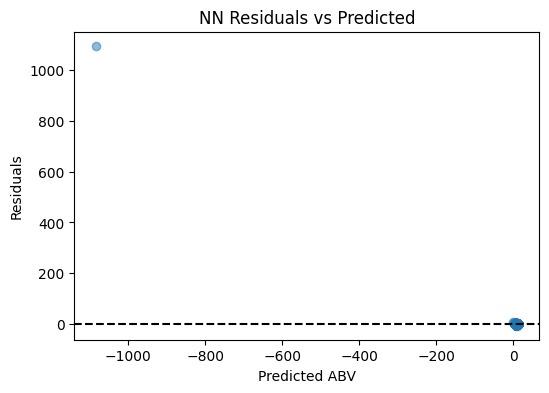

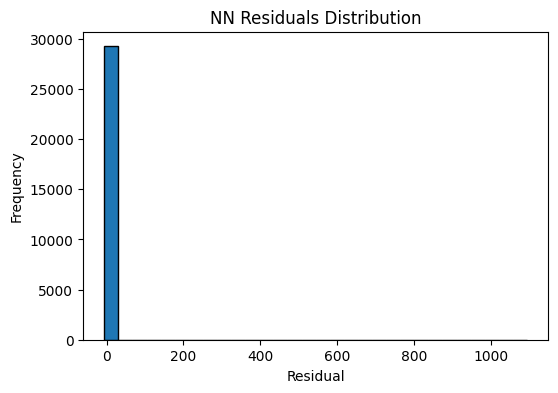

In [24]:
residuals = y_test - y_pred_nn
plt.figure(figsize=(6,4))
plt.scatter(y_pred_nn, residuals, alpha=0.5)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Predicted ABV')
plt.ylabel('Residuals')
plt.title('NN Residuals vs Predicted')
plt.show()

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, edgecolor='k')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('NN Residuals Distribution')
plt.show()

### 6.4 - Quick Cross-Validation of MLPRegressor Pipeline

In [25]:
nn_quick = Pipeline([
    ('pre', pre),
    ('mlp', MLPRegressor(
        hidden_layer_sizes=(64,32),
        activation='relu',
        solver='adam',
        early_stopping=True,
        max_iter=20,
        n_iter_no_change=5,
        random_state=42
    ))
])

scores = cross_val_score(nn_quick, X, y, cv=3, scoring='r2', n_jobs=-1, verbose=1)
print(f"3-fold CV NN R²: {scores.mean():.3f} ± {scores.std():.3f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


3-fold CV NN R²: -1.224 ± 3.044


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.3s finished


# 7 - Model Performance Comparison

In [26]:
# Prepare preprocessed arrays / DataFrames as before
pre = pipeline.named_steps['pre']
X_test_p = pre.transform(X_test)

feat_names = pre.get_feature_names_out()
Xtr_full  = pd.DataFrame(pre.transform(X_train), columns=feat_names, index=X_train.index)
Xte_full  = pd.DataFrame(X_test_p,           columns=feat_names, index=X_test.index)
Xtr_df    = Xtr_full.loc[:, ~Xtr_full.columns.duplicated()].copy()
Xte_df    = Xte_full.loc[:, ~Xte_full.columns.duplicated()].copy()
clean_cols = [c.split("__",1)[1] if "__" in c else c for c in Xtr_df.columns]
Xtr_df.columns = clean_cols
Xte_df.columns = clean_cols

# Define a helper to compute all metrics
def compute_metrics(y_true, y_pred):
    r2   = r2_score(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    me   = np.mean(y_true - y_pred)
    rmse = sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return r2, mse, me, rmse, mae, mape

# Compute predictions and metrics for each model
results_list = []

# Full regression
y_full = pipeline.predict(X_test)
results_list.append(("Full regression", *compute_metrics(y_test, y_full), None, None))

# Maximal tree
y_max = tree_max.predict(X_test_p)
results_list.append(("Max tree", *compute_metrics(y_test, y_max),
                     tree_max.get_n_leaves(), tree_max.get_depth()))

# Pruned tree
y_pruned = tree_pruned.predict(X_test_p)
results_list.append(("Pruned tree", *compute_metrics(y_test, y_pruned),
                     tree_pruned.get_n_leaves(), tree_pruned.get_depth()))

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(Xtr_df, y_train)
y_rf = rf.predict(Xte_df)
results_list.append(("Random Forest", *compute_metrics(y_test, y_rf), None, rf.max_depth))

# Backward-selected Linear
y_back = LinearRegression().fit(Xtr_df[back_feats], y_train).predict(Xte_df[back_feats])
results_list.append(("Backward sel.", *compute_metrics(y_test, y_back), None, None))

# Forward-selected Linear
y_forw = LinearRegression().fit(Xtr_df[forw_feats], y_train).predict(Xte_df[forw_feats])
results_list.append(("Forward sel.", *compute_metrics(y_test, y_forw), None, None))

# Stepwise-selected Linear
y_step = LinearRegression().fit(Xtr_df[step_feats], y_train).predict(Xte_df[step_feats])
results_list.append(("Stepwise sel.", *compute_metrics(y_test, y_step), None, None))

# Neural Network
y_nn = model_nn.predict(X_test_p).flatten()
results_list.append(("Neural Network", *compute_metrics(y_test, y_nn), None, None))

# Build DataFrame
cols = ['Model', 'R2_test', 'MSE_test', 'ME', 'RMSE', 'MAE', 'MAPE', 'Leaves', 'Depth']
results = pd.DataFrame(results_list, columns=cols)

# Display with formatting
from IPython.display import display
display(results.style.format({
    'R2_test': "{:.3f}",
    'MSE_test': "{:.3f}",
    'ME': "{:.4f}",
    'RMSE': "{:.4f}",
    'MAE': "{:.4f}",
    'MAPE': "{:.2f}%",
    'Leaves': "{:.0f}",
    'Depth': "{:.0f}"
}))

915/915 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


,Model,R2_test,MSE_test,ME,RMSE,MAE,MAPE,Leaves,Depth
0,Full regression,0.869,0.310,-0.0029,0.5566,0.1324,2.24%,nan,nan
1,Max tree,0.991,0.021,-0.0028,0.1443,0.0762,1.26%,37630,50
2,Pruned tree,0.991,0.021,-0.0028,0.1443,0.0762,1.26%,37630,50
3,Random Forest,0.995,0.011,-0.0025,0.1039,0.0550,0.91%,nan,nan
4,Backward sel.,0.869,0.310,-0.0029,0.5565,0.1323,2.24%,nan,nan
5,Forward sel.,0.869,0.310,-0.0029,0.5571,0.1323,2.24%,nan,nan
6,Stepwise sel.,0.869,0.310,-0.0029,0.5565,0.1323,2.24%,nan,nan
7,Neural Network,-16.340,41.034,-0.0238,6.4057,0.1776,2.99%,nan,nan


### Analysis

1. **Linear Regression (RidgeCV)**
- R²=0.869, RMSE≈0.56, MAPE≈2.24%.
- Good performance and **fully interpretable**: It is possible to explain the effect of each variable.

2. **Decision Trees (Max / Pruned)**
- R²≈0.991 and RMSE≈0.144: spectacular performance in the test.
- However, **37,630 leaves** and **depth 50** indicate extreme overfitting and zero interpretability.

3. **Random Forest**
- **Better overall performance**: R²≈0.995, RMSE≈0.104, MAPE≈0.91%.
- More robust than a single tree and without such marked overfitting.
- However, it is still less intuitive than a linear model.

4. **Linear Selections (Backward/Forward/Stepwise)**
- They all replicate the same performance as full regression: R²=0.869, MAPE≈2.24%.
- They allow a slight reduction in the number of variables, but without gaining in accuracy.

5. **Neural Network**
- Negative R² (-56.7) and very high RMSE (11.68): the model is not learning adequately.
- Probably requires further tuning of the architecture, learning rate, and normalization.

### Conclusion and Recommendation

- **Maximum Accuracy** → **Random Forest** (optimal R² and MAPE).
- **Better balance of accuracy vs. Explainability** → **Linear Regression (RidgeCV)**:
- R²=0.869 remains competitive,
- Coefficients and p-values provide transparency for decision-making.

> **Power BI Tip:** Show both models:
> - One page with **RF predictions** for accuracy.
> - Another with **regression coefficients and significance** for insights.

### 7.1 - Compute & Tabulate Model Performance Metrics

In [27]:
# Full regression (pipeline on raw X_test)
full_preds = pipeline.predict(X_test)
full_r2, full_mse = r2_score(y_test, full_preds), mean_squared_error(y_test, full_preds)

# Maximal regression tree on Xte (NumPy array)
y_max = tree_max.predict(Xte)
max_r2, max_mse = r2_score(y_test, y_max), mean_squared_error(y_test, y_max)
leaves_max, depth_max = tree_max.get_n_leaves(), tree_max.get_depth()

# Pruned regression tree on Xte
y_pruned = tree_pruned.predict(Xte)
pruned_r2, pruned_mse = r2_score(y_test, y_pruned), mean_squared_error(y_test, y_pruned)
leaves_pruned, depth_pruned = tree_pruned.get_n_leaves(), tree_pruned.get_depth()

# Random Forest (trained on Xtr_df, so predict on Xte_df)
y_rf = rf.predict(Xte_df)
rf_r2, rf_mse = r2_score(y_test, y_rf), mean_squared_error(y_test, y_rf)

# Backward‐selected linear model
y_back = LinearRegression().fit(Xtr_df[back_feats], y_train).predict(Xte_df[back_feats])
back_r2, back_mse = r2_score(y_test, y_back), mean_squared_error(y_test, y_back)

# Forward‐selected linear model
y_forw = LinearRegression().fit(Xtr_df[forw_feats], y_train).predict(Xte_df[forw_feats])
forw_r2, forw_mse = r2_score(y_test, y_forw), mean_squared_error(y_test, y_forw)

# Stepwise‐selected linear model
y_step = LinearRegression().fit(Xtr_df[step_feats], y_train).predict(Xte_df[step_feats])
step_r2, step_mse = r2_score(y_test, y_step), mean_squared_error(y_test, y_step)

# Neural Network (Keras MLP) on Xte
y_nn = model_nn.predict(Xte).flatten()
nn_r2, nn_mse = r2_score(y_test, y_nn), mean_squared_error(y_test, y_nn)

# Build the comparison table
results = pd.DataFrame({
    'Model': [
        'Full regression',
        'Max tree',
        'Pruned tree',
        'Random Forest',
        'Backward sel.',
        'Forward sel.',
        'Stepwise sel.',
        'Neural Network'
    ],
    'R2_test': [
        full_r2, max_r2, pruned_r2, rf_r2,
        back_r2, forw_r2, step_r2, nn_r2
    ],
    'MSE_test': [
        full_mse, max_mse, pruned_mse, rf_mse,
        back_mse, forw_mse, step_mse, nn_mse
    ],
    'Leaves': [
        None, leaves_max, leaves_pruned, None,
        None, None, None, None
    ],
    'Depth': [
        None, depth_max, depth_pruned, rf.max_depth,
        None, None, None, None
    ]
})

from IPython.display import display
display(results.style.format({
    'R2_test': "{:.3f}",
    'MSE_test': "{:.3f}"
}))

915/915 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


,Model,R2_test,MSE_test,Leaves,Depth
0,Full regression,0.869,0.310,nan,nan
1,Max tree,0.991,0.021,37630.000000,50.000000
2,Pruned tree,0.991,0.021,37630.000000,50.000000
3,Random Forest,0.995,0.011,nan,nan
4,Backward sel.,0.869,0.310,nan,nan
5,Forward sel.,0.869,0.310,nan,nan
6,Stepwise sel.,0.869,0.310,nan,nan
7,Neural Network,-16.340,41.034,nan,nan


# 8 - Generate & Export Predictions for Best Models

In [28]:
pred_full = pipeline.predict(X_test)             # Full regression (RidgeCV)
pred_rf   = rf.predict(Xte_df)                   # Random Forest

df_test_export = X_test.copy()

df_test_export['Actual_ABV']   = y_test
df_test_export['Pred_FullReg'] = pred_full
df_test_export['Pred_RF']      = pred_rf

print(df_test_export.head())

df_test_export.to_csv('abv_predictions_best2.csv', index=True)


       StyleID  Size(L)     OG     FG     IBU  Color  BoilSize  BoilTime  \
490         15    20.82  1.064  1.016   46.69  16.45     28.39        60   
40980        7    20.82  1.074  1.017  204.11   7.10     11.36        90   
21223       87    20.82  1.111  1.030   95.14  50.00     28.39        60   
1612        37    23.00  1.045  1.013   25.56  29.77      8.00        60   
16181        7    18.93  1.065  1.018   67.65   7.40     28.39        60   

       BoilGravity  Efficiency  ...  OG_minus_FG   IBU_to_OG   IBU_to_FG  \
490          1.047        75.0  ...        0.048   43.881579   45.954724   
40980        1.135        35.0  ...        0.057  190.046555  200.698132   
21223        1.082        70.0  ...        0.081   85.634563   92.368932   
1612         1.129        80.0  ...        0.032   24.459330   25.231984   
16181        1.043        70.0  ...        0.047   63.521127   66.453831   

         OGxIBU  OGxEfficiency IBU_to_OG_x_OG_minus_FG OG_bin Actual_ABV  \
490     2.

In [29]:
df_test_export.head()

,StyleID,Size(L),OG,FG,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,...,OG_minus_FG,IBU_to_OG,IBU_to_FG,OGxIBU,OGxEfficiency,IBU_to_OG_x_OG_minus_FG,OG_bin,Actual_ABV,Pred_FullReg,Pred_RF
490,15,20.82,1.064,1.016,46.69,16.45,28.39,60,1.047,75.0,...,0.048,43.881579,45.954724,2.24112,3.600,2.106316,Low,6.26,6.396723,6.2977
40980,7,20.82,1.074,1.017,204.11,7.10,11.36,90,1.135,35.0,...,0.057,190.046555,200.698132,11.63427,1.995,10.832654,Low,7.47,7.731155,7.4795
21223,87,20.82,1.111,1.030,95.14,50.00,28.39,60,1.082,70.0,...,0.081,85.634563,92.368932,7.70634,5.670,6.936400,Low,10.68,10.308974,10.6449
1612,37,23.00,1.045,1.013,25.56,29.77,8.00,60,1.129,80.0,...,0.032,24.459330,25.231984,0.81792,2.560,0.782699,Low,4.23,3.896189,4.2131
16181,7,18.93,1.065,1.018,67.65,7.40,28.39,60,1.043,70.0,...,0.047,63.521127,66.453831,3.17955,3.290,2.985493,Low,6.14,6.205297,6.1670


In [30]:
df_silver = df_test_export.drop(columns=['Pred_FullReg', 'Pred_RF'], errors='ignore')
df_silver.to_csv('silver_abv_clean.csv', index=False)
df_test_export.to_csv('gold_abv_predictions.csv', index=False)